In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, accuracy_score, mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_parquet("data/flights_processed.parquet")
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIGIN_LAT,ORIGIN_LON,DEST_LAT,DEST_LON
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,-22,0,0,0,0,0,61.17432,-149.99619,47.44898,-122.30931
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,-9,0,0,0,0,0,33.94254,-118.40807,26.68316,-80.09559
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,5,0,0,0,0,0,37.61900,-122.37484,35.21401,-80.94313
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,-9,0,0,0,0,0,33.94254,-118.40807,25.79325,-80.29056
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,-21,0,0,0,0,0,47.44898,-122.30931,61.17432,-149.99619


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5231130 entries, 0 to 5231129
Data columns (total 32 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       int64  
 11  DEPARTURE_DELAY      int64  
 12  TAXI_OUT             int64  
 13  WHEELS_OFF           int64  
 14  SCHEDULED_TIME       int64  
 15  ELAPSED_TIME         int64  
 16  AIR_TIME             int64  
 17  DISTANCE             int64  
 18  WHEELS_ON            int64  
 19  TAXI_IN              int64  
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         int64  
 22  ARRIVAL_DELAY        int64  
 23  AIR_SYSTEM_DELAY     int64  
 24

In [4]:
NUM = []
CAT = []
for col in df.columns.values:
    if df[col].dtype in ["float64", "int64"]:
        NUM.append(col)
    else:
        CAT.append(col)
print("NUMERIC COLUMNS:", NUM)
print("CATEGORICAL COLUMNS", CAT)

NUMERIC COLUMNS: ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'FLIGHT_NUMBER', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'ORIGIN_LAT', 'ORIGIN_LON', 'DEST_LAT', 'DEST_LON']
CATEGORICAL COLUMNS ['AIRLINE', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']


In [5]:
corr_arr = df[NUM].corrwith(df["ARRIVAL_DELAY"]).sort_values(ascending=False)
corr_arr

/home/nemo/.conda/envs/npn/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nemo/.conda/envs/npn/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


ARRIVAL_DELAY          1.000000
DEPARTURE_DELAY        0.945214
LATE_AIRCRAFT_DELAY    0.625248
AIRLINE_DELAY          0.624979
AIR_SYSTEM_DELAY       0.425103
WEATHER_DELAY          0.272189
TAXI_OUT               0.228029
DEPARTURE_TIME         0.162783
WHEELS_OFF             0.158629
TAXI_IN                0.117801
SCHEDULED_DEPARTURE    0.103093
SCHEDULED_ARRIVAL      0.090906
WHEELS_ON              0.059203
ARRIVAL_TIME           0.050162
ELAPSED_TIME           0.030368
SECURITY_DELAY         0.028320
FLIGHT_NUMBER          0.017446
DEST_LON               0.014817
ORIGIN_LON             0.008007
DEST_LAT              -0.002156
DAY                   -0.003883
AIR_TIME              -0.006338
ORIGIN_LAT            -0.006928
DAY_OF_WEEK           -0.021279
DISTANCE              -0.024594
MONTH                 -0.026466
SCHEDULED_TIME        -0.028977
YEAR                        NaN
dtype: float64

In [6]:
corr_matrix = df[NUM].corr()

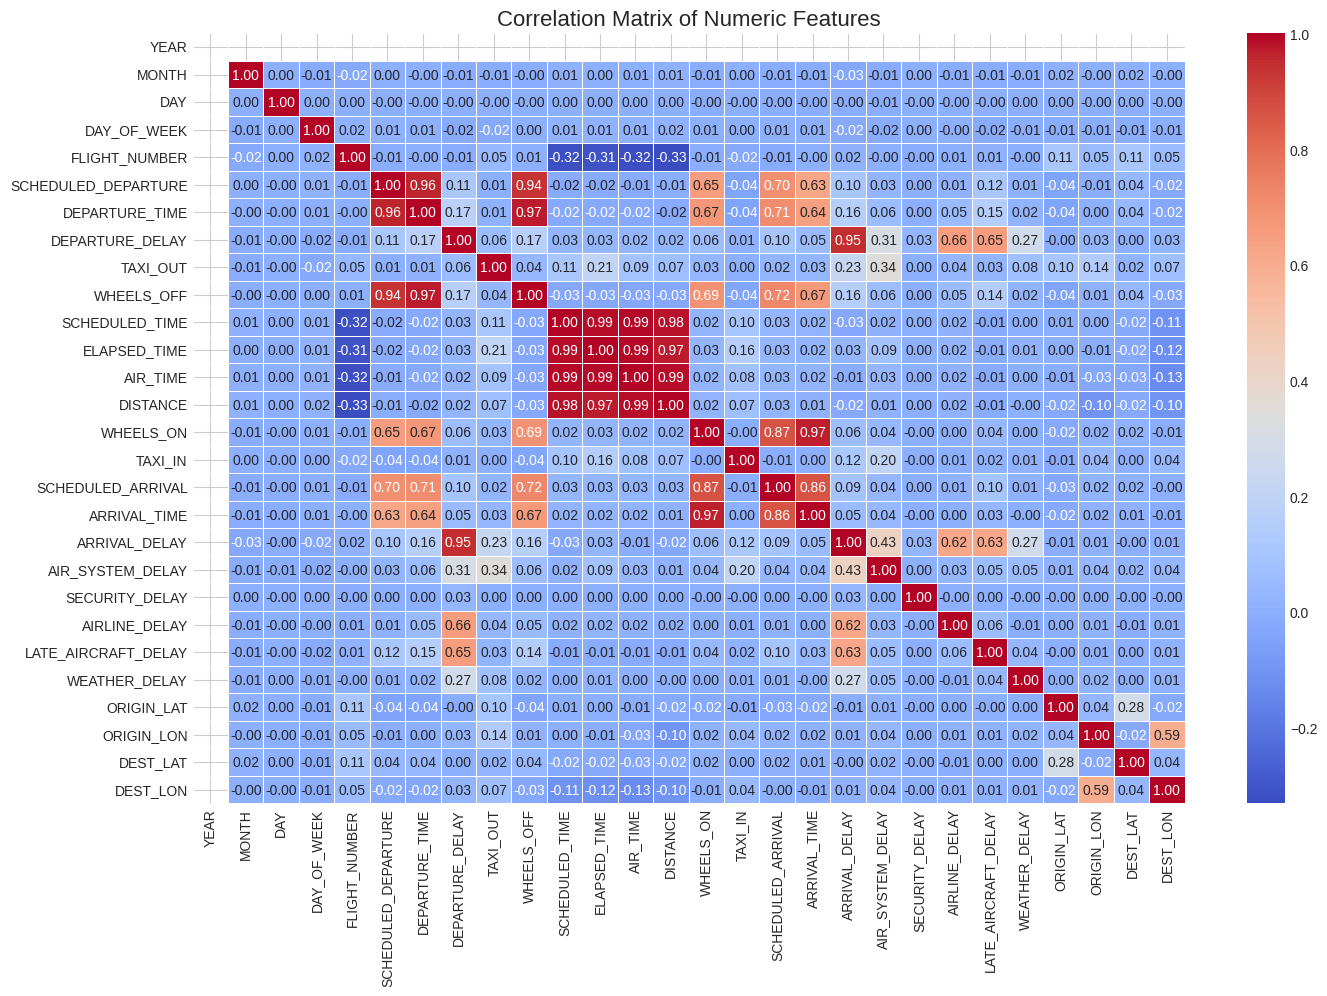

In [7]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 10))
sns.heatmap(data=corr_matrix, cmap="coolwarm", fmt=".2f", annot=True, linewidths=.5)
plt.title("Correlation Matrix of Numeric Features", fontsize=16)
plt.show()


In [8]:
df["YEAR"].value_counts()

YEAR
2015    5231130
Name: count, dtype: int64

In [13]:
corr_dep = df[NUM].corrwith(df["DEPARTURE_DELAY"]).sort_values(ascending=False)
corr_dep

/home/nemo/.conda/envs/npn/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nemo/.conda/envs/npn/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


DEPARTURE_DELAY        1.000000
ARRIVAL_DELAY          0.945214
AIRLINE_DELAY          0.655139
LATE_AIRCRAFT_DELAY    0.654422
AIR_SYSTEM_DELAY       0.305022
WEATHER_DELAY          0.267259
DEPARTURE_TIME         0.174820
WHEELS_OFF             0.165465
SCHEDULED_DEPARTURE    0.113375
SCHEDULED_ARRIVAL      0.099751
WHEELS_ON              0.059204
TAXI_OUT               0.059137
ARRIVAL_TIME           0.049719
ORIGIN_LON             0.031615
ELAPSED_TIME           0.030515
SECURITY_DELAY         0.028563
SCHEDULED_TIME         0.027278
DEST_LON               0.025412
DISTANCE               0.023548
AIR_TIME               0.022972
TAXI_IN                0.013335
DEST_LAT               0.001867
DAY                   -0.000657
ORIGIN_LAT            -0.003671
FLIGHT_NUMBER         -0.008977
MONTH                 -0.011668
DAY_OF_WEEK           -0.015070
YEAR                        NaN
dtype: float64

In [9]:
target = "ARRIVAL_DELAY"
y = df[target]
X = df.drop(columns=[target])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2)

In [10]:
num_cols = NUM.copy()
cat_cols = CAT.copy()
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
# Preprocessing for categorical features: impute (to a new category), then one-hot encode
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine into a single ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# Full pipeline: preprocessing followed by a regressor
model = Pipeline([
    ('preproc', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [11]:
# Perform 5-fold cross-validation (shuffle data for randomness)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
print("5-fold CV R^2 scores:", r2_scores)
print("Mean R^2:", r2_scores.mean())


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/nemo/.conda/envs/npn/lib/python3.12/site-packages/pandas/core/indexes/base.py", line 3812, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7088, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7096, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'ARRIVAL_DELAY'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/nemo/.conda/envs/npn/lib/python3.12/site-packages/sklearn/utils/_indexing.py", line 443, in _get_column_indices
    col_idx = all_columns.get_loc(col)
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/nemo/.conda/envs/npn/lib/python3.12/site-packages/pandas/core/indexes/base.py", line 3819, in get_loc
    raise KeyError(key) from err
KeyError: 'ARRIVAL_DELAY'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/nemo/.conda/envs/npn/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nemo/.conda/envs/npn/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/nemo/.conda/envs/npn/lib/python3.12/site-packages/sklearn/pipeline.py", line 655, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/nemo/.conda/envs/npn/lib/python3.12/site-packages/sklearn/pipeline.py", line 589, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/nemo/.conda/envs/npn/lib/python3.12/site-packages/joblib/memory.py", line 326, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/nemo/.conda/envs/npn/lib/python3.12/site-packages/sklearn/pipeline.py", line 1540, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/nemo/.conda/envs/npn/lib/python3.12/site-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/nemo/.conda/envs/npn/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/nemo/.conda/envs/npn/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py", line 988, in fit_transform
    self._validate_column_callables(X)
  File "/home/nemo/.conda/envs/npn/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py", line 541, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
                                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/nemo/.conda/envs/npn/lib/python3.12/site-packages/sklearn/utils/_indexing.py", line 451, in _get_column_indices
    raise ValueError("A given column is not a column of the dataframe") from e
ValueError: A given column is not a column of the dataframe


In [ ]:
# Inspect your pipeline and ColumnTransformer
print("Pipeline steps:", model.named_steps.keys())

# Find the ColumnTransformer (it might be named differently)
for step_name, step in model.named_steps.items():
    print(f"Step: {step_name}, Type: {type(step)}")
    if hasattr(step, 'transformers_'):
        print("ColumnTransformer found!")
        print("Transformers configuration:")
        for name, transformer, columns in step.transformers_:
            print(f"  Name: {name}")
            print(f"  Transformer: {transformer}")
            print(f"  Columns: {columns}")
            print(f"  Columns type: {type(columns)}")
            print("---")

Pipeline steps: dict_keys(['preproc', 'regressor'])
Step: preproc, Type: <class 'sklearn.compose._column_transformer.ColumnTransformer'>
Step: regressor, Type: <class 'sklearn.ensemble._forest.RandomForestRegressor'>


In [ ]:
# Step 1: Debug your current variables
print("=== DEBUGGING ===")
print("NUM list:", NUM)
print("CAT list:", CAT)
print("X_train columns:", X_train.columns.tolist())
print("Does 'ARRIVAL_DELAY' exist in X_train?", 'ARRIVAL_DELAY' in X_train.columns)
print()

# Step 2: Create safe column lists based on what's actually in X_train
# Get numeric and categorical columns that actually exist in X_train
actual_numeric_cols = []
actual_categorical_cols = []

# Check each column in NUM and CAT to see if it exists in X_train
for col in NUM:
    if col in X_train.columns:
        actual_numeric_cols.append(col)
    else:
        print(f"WARNING: Numeric column '{col}' not found in X_train")

for col in CAT:
    if col in X_train.columns:
        actual_categorical_cols.append(col)
    else:
        print(f"WARNING: Categorical column '{col}' not found in X_train")

print("Filtered numeric columns:", actual_numeric_cols)
print("Filtered categorical columns:", actual_categorical_cols)
print()

# Step 3: Alternative approach - automatically detect column types
print("=== ALTERNATIVE: AUTO-DETECT COLUMNS ===")
auto_numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
auto_categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print("Auto-detected numeric columns:", auto_numeric_cols)
print("Auto-detected categorical columns:", auto_categorical_cols)
print()

# Step 4: Create the corrected pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# Use the actual columns that exist (choose one approach)
# Option 1: Use filtered original lists
# numeric_cols_to_use = actual_numeric_cols
# categorical_cols_to_use = actual_categorical_cols

# Option 2: Use auto-detected columns (recommended if NUM/CAT are problematic)
numeric_cols_to_use = auto_numeric_cols
categorical_cols_to_use = auto_categorical_cols

print("Using numeric columns:", numeric_cols_to_use)
print("Using categorical columns:", categorical_cols_to_use)

# Create transformers
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create preprocessor with existing columns only
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols_to_use),
    ('cat', categorical_transformer, categorical_cols_to_use)
])

# Create the full pipeline
model = Pipeline([
    ('preproc', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

print("Pipeline created successfully!")

# Step 5: Test the pipeline before cross-validation
print("\n=== TESTING PIPELINE ===")
try:
    # Test fitting
    model.fit(X_train, y_train)
    print("✓ Pipeline fitting successful!")
    
    # Test prediction
    y_pred = model.predict(X_test)
    print("✓ Pipeline prediction successful!")
    print("Prediction shape:", y_pred.shape)
    
except Exception as e:
    print("✗ Pipeline test failed:", str(e))
    print("Need to investigate further...")

# Step 6: Run cross-validation if test passes
print("\n=== CROSS-VALIDATION ===")
try:
    from sklearn.model_selection import KFold, cross_val_score
    
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    r2_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
    print("✓ Cross-validation successful!")
    print("5-fold CV R^2 scores:", r2_scores)
    print("Mean R^2:", r2_scores.mean())
    print("Std R^2:", r2_scores.std())
    
except Exception as e:
    print("✗ Cross-validation failed:", str(e))

=== DEBUGGING ===
NUM list: ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'FLIGHT_NUMBER', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'ORIGIN_LAT', 'ORIGIN_LON', 'DEST_LAT', 'DEST_LON']
CAT list: ['AIRLINE', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']
X_train columns: ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'ORIGIN_LAT', 'ORIGIN_LON',

In [ ]:
print(f"Mean of Arrival delay: {df["ARRIVAL_DELAY"].mean()}")
print(f"Median of Arrival delay: {df["ARRIVAL_DELAY"].median()}")
print(f"Max of Arrival delay: {df["ARRIVAL_DELAY"].max()}")
print(f"Min of Arrival delay: {df["ARRIVAL_DELAY"].min()}")
print(f"Variance of Arrival delay: {df["ARRIVAL_DELAY"].var()}")
print(f"STD of Arrival delay: {df["ARRIVAL_DELAY"].std()}")

Mean of Arrival delay: 4.885903045804635
Median of Arrival delay: -5.0
Max of Arrival delay: 1971
Min of Arrival delay: -87
Variance of Arrival delay: 1583.0276750101762
STD of Arrival delay: 39.78728031683212


In [ ]:
Q1 = df["ARRIVAL_DELAY"].quantile(0.25)
Q3 = df["ARRIVAL_DELAY"].quantile(0.75)
IQR = Q3 - Q1
print("IQR: ", IQR)
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
print(f"UPPER BOUND: {upper}")
print(f"LOWER BOUND: {lower}")

outliers = df[(df["ARRIVAL_DELAY"] < lower) | (df["ARRIVAL_DELAY"] > upper)]
print(f"Number of outliers: ", outliers.shape[0])
df_no_outliers = df.drop(outliers.index)
df_no_outliers.head()

IQR:  21.0
UPPER BOUND: 39.5
LOWER BOUND: -44.5
Number of outliers:  485923


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIGIN_LAT,ORIGIN_LON,DEST_LAT,DEST_LON
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,-22,0,0,0,0,0,61.17432,-149.99619,47.44898,-122.30931
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,-9,0,0,0,0,0,33.94254,-118.40807,26.68316,-80.09559
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,5,0,0,0,0,0,37.61900,-122.37484,35.21401,-80.94313
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,-9,0,0,0,0,0,33.94254,-118.40807,25.79325,-80.29056
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,-21,0,0,0,0,0,47.44898,-122.30931,61.17432,-149.99619


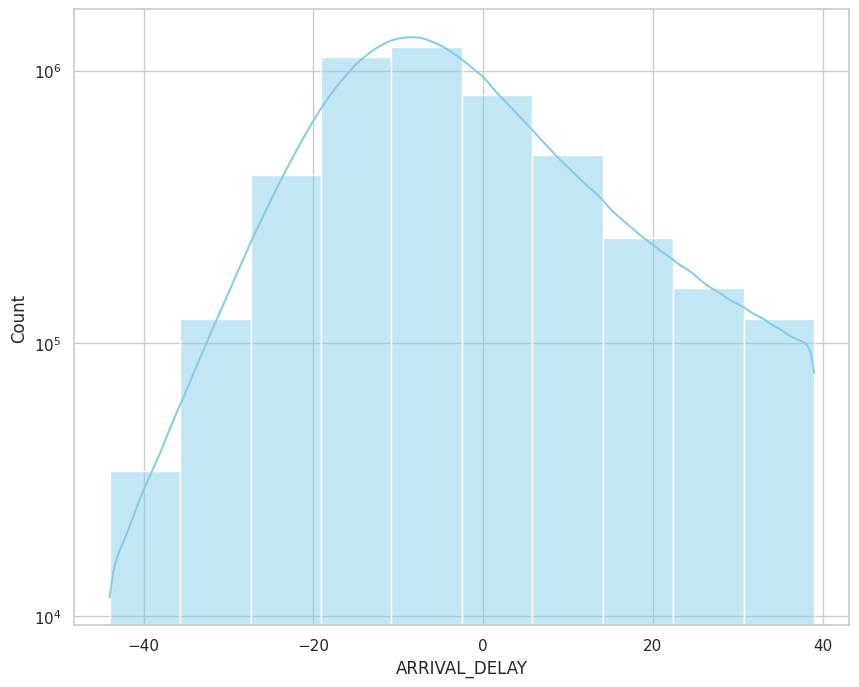

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 8))
sns.histplot(data=df_no_outliers, x="ARRIVAL_DELAY", bins=10, kde=True, color="skyblue")
plt.yscale('log')
plt.show()